In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/sample_submission.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/train.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/test.csv


# Importing Libraries

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (log_loss,
                            accuracy_score,
                            precision_score,
                            recall_score,
                            f1_score,
                            log_loss,
                            roc_auc_score,
                            confusion_matrix,
                            roc_curve,
                            precision_recall_curve,
                            classification_report)


from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


from sklearn.model_selection import GridSearchCV
from scipy.stats import randint,uniform
from sklearn.model_selection import RandomizedSearchCV

import os


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Reading the Dataset

In [4]:
# Reading the Datasets

train_data  = pd.read_csv('/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/train.csv')
test_data  = pd.read_csv('/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/test.csv')

sample_submission = pd.read_csv('/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/sample_submission.csv')
print(f'train_data_data shape {train_data.shape} \n')
print('train_data_data')
print(train_data.head())
print(f'test_data_data shape {test_data.shape} \n')
print('test_data_data')
print(test_data.head())
print(f'sample_submission {sample_submission.shape} \n')
print('sample_submission')
print(sample_submission.head())

train_data_data shape (29500, 14) 

train_data_data
   id  adults  children  weekends  weekdays     meal_type    room_type  \
0   0       2         0         0         1  Not Selected  Room_Type 1   
1   1       1         0         3         6  Not Selected  Room_Type 1   
2   2       2         0         0         2   Meal Plan 1  Room_Type 2   
3   3       1         0         2         1   Meal Plan 1  Room_Type 1   
4   4       2         0         2         3   Meal Plan 1  Room_Type 1   

      arrival  lead_time    segment  repeat   price  requests  booking_status  
0  2018-05-21       54.0     Online       0  116.10         0               1  
1  2018-11-12       12.0     Online       0   71.87         1               1  
2  2018-01-06       34.0     Online       0   71.55         1               0  
3  2018-02-14        4.0  Corporate       1   66.00         0               0  
4  2018-07-08      155.0    Offline       0   72.25         0               0  
test_data_data shape (7

# Identify data types of different columns

In [5]:
# as we can here we have null values in some columns
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29500 entries, 0 to 29499
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              29500 non-null  int64  
 1   adults          29500 non-null  int64  
 2   children        29500 non-null  int64  
 3   weekends        29500 non-null  int64  
 4   weekdays        29500 non-null  int64  
 5   meal_type       29500 non-null  object 
 6   room_type       28659 non-null  object 
 7   arrival         29500 non-null  object 
 8   lead_time       27805 non-null  float64
 9   segment         29500 non-null  object 
 10  repeat          29500 non-null  int64  
 11  price           27917 non-null  float64
 12  requests        29500 non-null  int64  
 13  booking_status  29500 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 3.2+ MB


# Data Viz

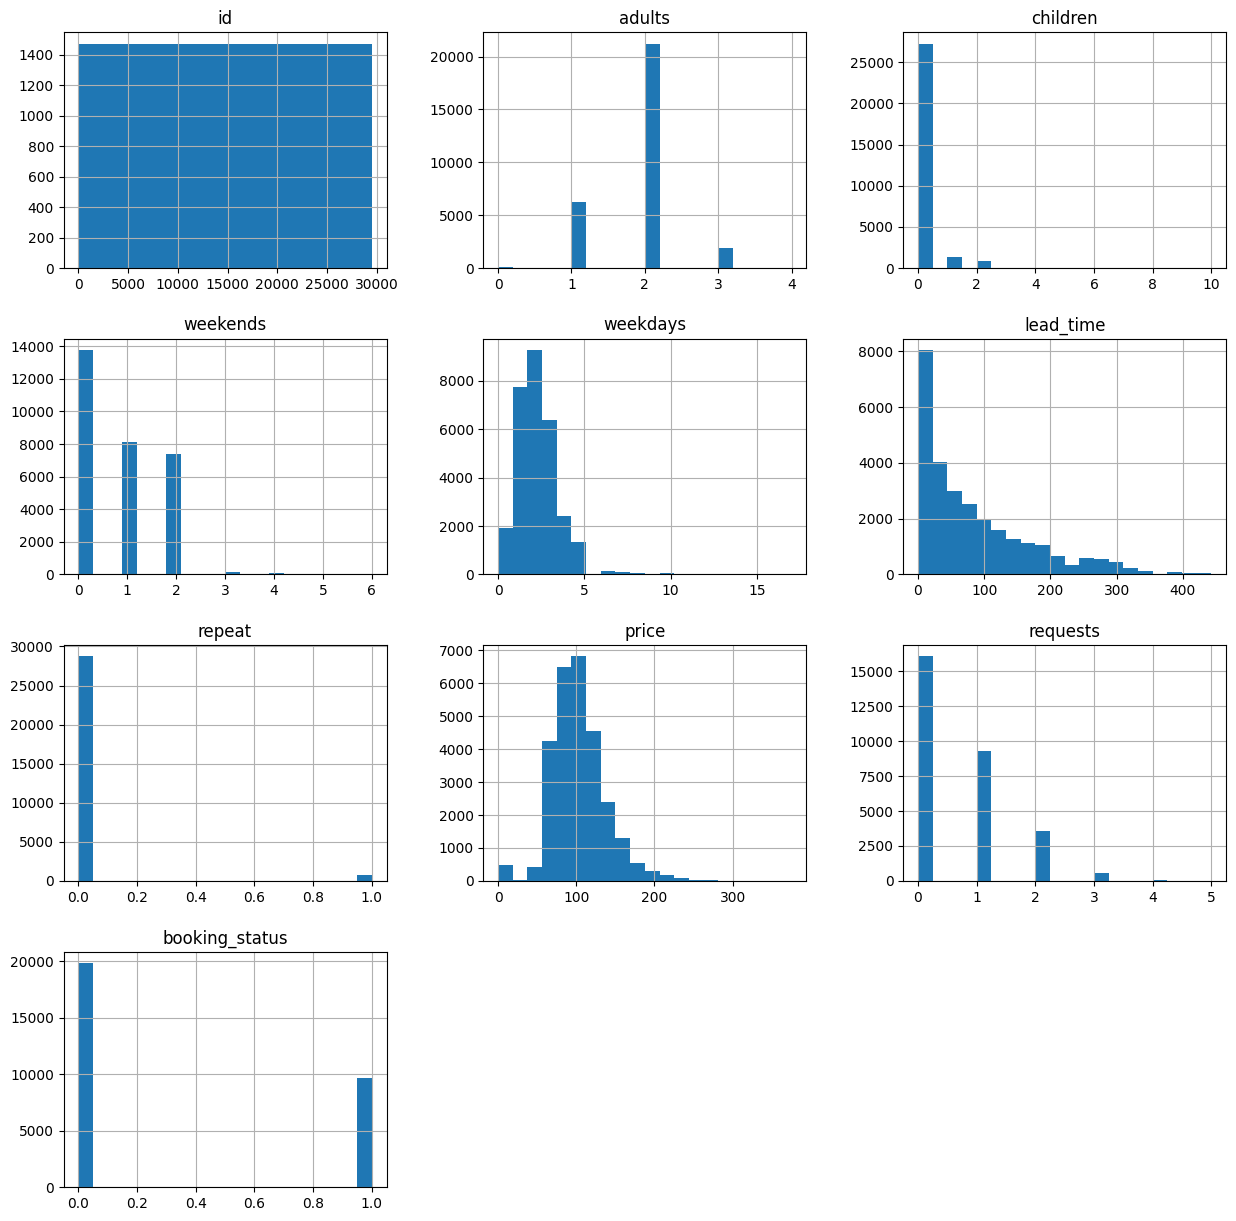

In [6]:
import seaborn as sns

train_data.hist(bins = 20,figsize = (15,15))
plt.show()

lead_time right skewed so we we will use meadian fill null values

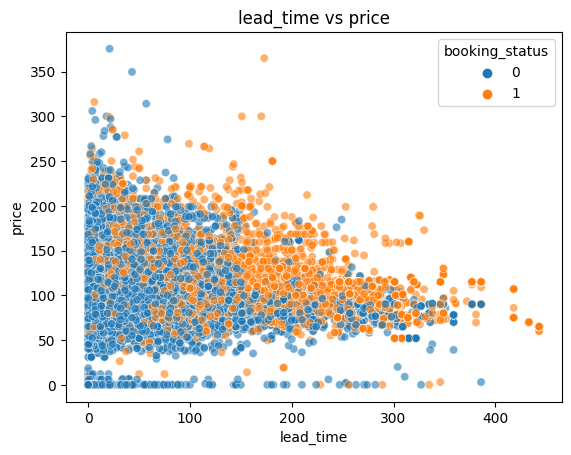

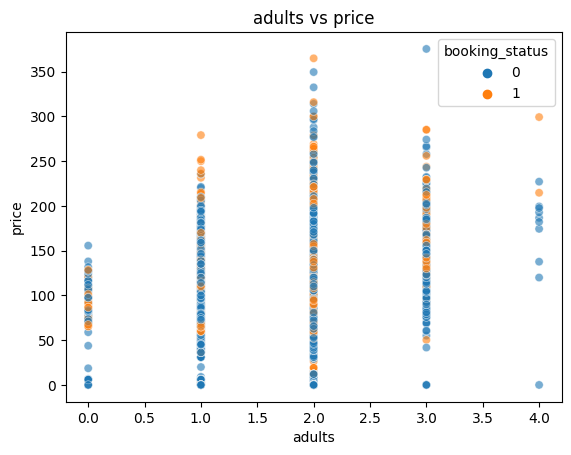

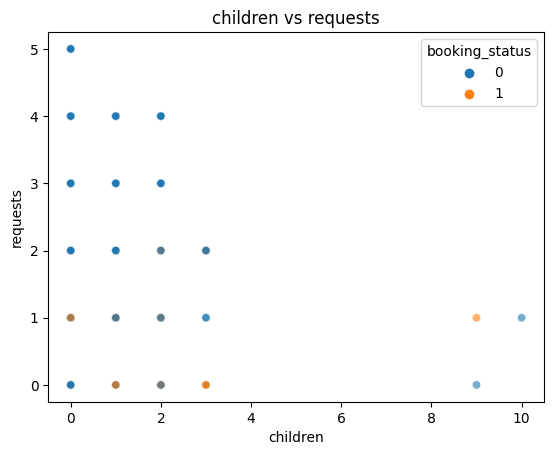

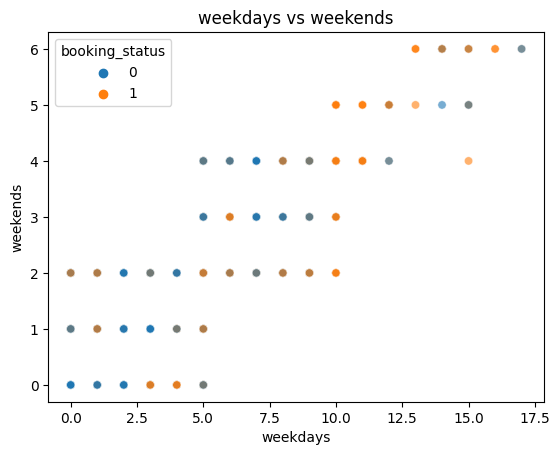

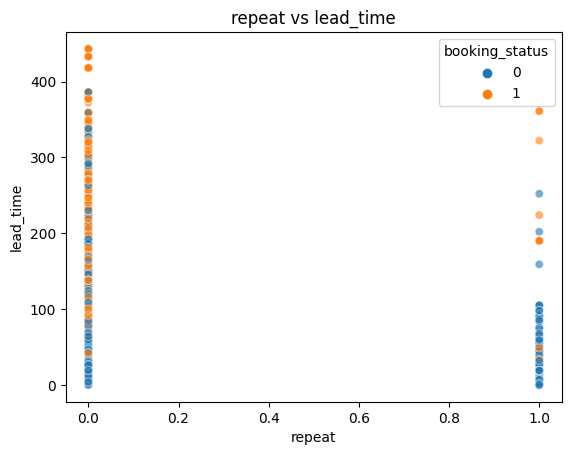

In [7]:
pairs = [
    ("lead_time", "price"),
    ("adults", "price"),
    ("children", "requests"),
    ("weekdays", "weekends"),
    ("repeat", "lead_time")
]

for x,y in pairs:
    sns.scatterplot(data=train_data, x=x, y=y, hue="booking_status", alpha=0.6)
    plt.title(f"{x} vs {y}")
    plt.show()


1. Data is mostly cluster so we tree based algorithm needs more number of columns to make decision
1. low_lead time tends have higher hotel price
2. overall data is clustured

## Data Transformation

In [8]:
# In the arrival column we have some value like 2020-13-12 and 2020-13-12 that is why we will remove this columns and we have extracted month and season columns
train_data['arrival'] = pd.to_datetime(train_data['arrival'], errors='coerce')
test_data['arrival']  = pd.to_datetime(test_data['arrival'], errors='coerce')

median_arr = train_data['arrival'].median()

train_data['arrival'] = train_data['arrival'].fillna(median_arr)
test_data['arrival']  = test_data['arrival'].fillna(median_arr)

train_data['arrival_year'] = train_data['arrival'].dt.year
train_data['arrival_month'] = train_data['arrival'].dt.month
train_data['arrival_day'] = train_data['arrival'].dt.day

test_data['arrival_year'] = test_data['arrival'].dt.year
test_data['arrival_month'] = test_data['arrival'].dt.month
test_data['arrival_day'] = test_data['arrival'].dt.day

train_data.drop('arrival', axis=1, inplace=True)
test_data.drop('arrival', axis=1, inplace=True)

In [9]:
train_data['total_days'] = train_data['weekdays'] + train_data['weekends']
test_data['total_days']  = test_data['weekdays'] + test_data['weekends']

train_data['total_people'] = train_data['adults'] + train_data['children']
test_data['total_people']  = test_data['adults'] + test_data['children']

train_data['price_per_person'] = train_data['price'] / (train_data['total_people'] + 1)
test_data['price_per_person']  = test_data['price'] / (test_data['total_people'] + 1)


# Checking which are the the hight cardinality

In [10]:
unique_counts = train_data.nunique()
constant_cols = unique_counts[unique_counts == 1].index.tolist()
high_card_cols = unique_counts[unique_counts > 40].index.tolist()

print("Constant columns:", constant_cols)
print("High-cardinality columns:", high_card_cols)


Constant columns: []
High-cardinality columns: ['id', 'lead_time', 'price', 'price_per_person']


# Cheking unique valuees in the columns

In [11]:
columns = train_data.columns.tolist()
for col in columns:
    print(f"unique values for {col} : {train_data[col].unique()}")

unique values for id : [    0     1     2 ... 29497 29498 29499]
unique values for adults : [2 1 3 0 4]
unique values for children : [ 0  1  2  9  3 10]
unique values for weekends : [0 3 2 1 5 4 6]
unique values for weekdays : [ 1  6  2  3  5  4  0 10  8  9 12 11  7 13 15 14 16 17]
unique values for meal_type : ['Not Selected' 'Meal Plan 1' 'Meal Plan 2' 'Meal Plan 3']
unique values for room_type : ['Room_Type 1' 'Room_Type 2' 'Room_Type 4' nan 'Room_Type 6' 'Room_Type 5'
 'Room_Type 7' 'Room_Type 3']
unique values for lead_time : [ 54.  12.  34.   4. 155. 106.   3.  33.  15. 121. 325.   0. 315.  80.
 276. 161.  nan  14.  18.  53. 443.  21. 105.  95.   1.  32. 164. 304.
 279.   5. 145.  22. 135. 150.  10.  35.  11.  19. 110.  42.  96. 349.
 172. 151.  52. 202. 128.  75. 179.  87.   9.  86. 182.  17.  93. 146.
 130. 188. 133.   7.  49.  20.  29. 287. 140.  64.  66.   6. 193. 192.
  84. 124.   2.  31. 190.  76. 203.  39. 102. 245. 231. 111.  48. 418.
 115.  63.  57. 236.  73.  99.  40. 1

1. **'Zero adult Make no sense'**
1. A child can not book a hotel on top of that if there is no adult

In [12]:
num_col = train_data.select_dtypes(include = ['int','float']).columns
train_data[num_col].describe()

,id,adults,children,weekends,weekdays,lead_time,repeat,price,requests,booking_status,arrival_year,arrival_month,arrival_day,total_days,total_people,price_per_person
count,29500.000000,29500.000000,29500.000000,29500.000000,29500.000000,27805.000000,29500.000000,27917.000000,29500.000000,29500.000000,29500.000000,29500.000000,29500.000000,29500.000000,29500.000000,27917.000000
mean,14749.500000,1.843559,0.106576,0.808136,2.202237,85.405431,0.026000,103.483304,0.619661,0.326441,2017.820136,7.423085,15.582508,3.010373,1.950136,35.781464
std,8516.060807,0.518711,0.405517,0.868835,1.404200,85.939750,0.159138,35.120922,0.785919,0.468919,0.384081,3.054387,8.727825,1.773821,0.650894,12.066682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,7374.750000,2.000000,0.000000,0.000000,1.000000,17.000000,0.000000,80.500000,0.000000,0.000000,2018.000000,5.000000,8.000000,2.000000,2.000000,28.500000
50%,14749.500000,2.000000,0.000000,1.000000,2.000000,58.000000,0.000000,99.880000,0.000000,0.000000,2018.000000,8.000000,16.000000,3.000000,2.000000,34.425000
75%,22124.250000,2.000000,0.000000,2.000000,3.000000,127.000000,0.000000,120.180000,1.000000,1.000000,2018.000000,10.000000,23.000000,4.000000,2.000000,41.700000
max,29499.000000,4.000000,10.000000,6.000000,17.000000,443.000000,1.000000,375.500000,5.000000,1.000000,2018.000000,12.000000,31.000000,23.000000,12.000000,139.600000


1. *mean is greater than meadian for price and well as lead_time***

In [13]:
print('missing values in train_data_data \n')
print(train_data.isna().sum())
print('missing values in test_data_data \n')
print(test_data.isna().sum())

missing values in train_data_data 

id                     0
adults                 0
children               0
weekends               0
weekdays               0
meal_type              0
room_type            841
lead_time           1695
segment                0
repeat                 0
price               1583
requests               0
booking_status         0
arrival_year           0
arrival_month          0
arrival_day            0
total_days             0
total_people           0
price_per_person    1583
dtype: int64
missing values in test_data_data 

id                     0
adults                 0
children               0
weekends               0
weekdays               0
meal_type              0
room_type           1660
lead_time            412
segment                0
repeat                 0
price                406
requests               0
arrival_year           0
arrival_month          0
arrival_day            0
total_days             0
total_people           0
price_per_person

In [14]:
train_data['booking_status'].value_counts()/int(train_data.shape[0])

booking_status
0    0.673559
1    0.326441
Name: count, dtype: float64

**Data is imbalance not that that much **

# Checking Duplicated

In [15]:
print(f"Duplicated rows in train_dataing data: {train_data.duplicated().sum()}")

train_data = train_data[~train_data.duplicated()]

Duplicated rows in train_dataing data: 0


We have removed duplicated rows

# Handling Outliers

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [43]:
plot1 = px.box(train_data,x = 'lead_time')
plot1.update_layout(title = 'Boxplot of lead_Time')
plot1.show()

In [18]:
# q1 = train_data['price'].quantile(0.25)
# q3 = train_data['price'].quantile(0.75)
# iqr = q3-q1
# lower = q1-1.5*iqr
# upper = q3+1.5*iqr

# upper

In [19]:
plot_2 = px.box(train_data,x = 'price')
plot_2.update_layout(title = 'boxplot of price ')
plot_2.show()

We will not remove outlier from thease two column because they are hightly correlated with target variable

In [20]:
plt3 = px.box(train_data,x = 'children')
plt3.update_layout(title = 'box of children')
plt3.show()

There could be 10 children maye they have come on vocation

0 Adult and children?? that is suspicious

In [21]:
train_data_data = train_data[~(train_data['adults'] == 0)]

# Data imputation

In [22]:
num_cols = ['id','adults','children','weekends','weekdays','lead_time','repeat',
            'price','requests','arrival_year','arrival_month','arrival_day','price_per_person']
cat_cols = ['meal_type','room_type','segment']

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

train_data[num_cols] = num_imputer.fit_transform(train_data[num_cols])
test_data[num_cols]  = num_imputer.transform(test_data[num_cols])

train_data[cat_cols] = cat_imputer.fit_transform(train_data[cat_cols])
test_data[cat_cols]  = cat_imputer.transform(test_data[cat_cols])


# Scaling and Encoding

In [23]:
train_data = pd.get_dummies(train_data, columns=['meal_type','room_type','segment'], drop_first=True)
test_data  = pd.get_dummies(test_data,  columns=['meal_type','room_type','segment'], drop_first=True)

train_data, test_data = train_data.align(test_data, join="left", axis=1)
test_data['booking_status'] = 0
test_data = test_data.drop('booking_status', axis=1)


# Splitting the data

In [24]:
x = train_data.drop('booking_status',axis = 1)
y = train_data['booking_status']

In [25]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size = 0.2,random_state = 7)

# training Model

# Logostic Regression

In [26]:
model_perf = dict()

In [27]:
# Logistic Regression without Regularazition

lgr = LogisticRegression(max_iter = 5000,random_state = 7) 

lgr.fit(x_train,y_train)
lgr_pred = lgr.predict(x_val)
val_pred = accuracy_score(lgr_pred,y_val)
print(f'test_data accuracy {val_pred}')


model_perf['LogisticRegression'] = val_pred

test_data accuracy 0.7911864406779661


# Logistic With SGD

In [28]:

sgd = SGDClassifier(loss='log_loss',
                        max_iter=5000,
                        warm_start=True,
                        eta0=0.01,
                        alpha=0,
                        shuffle = True,
                        learning_rate= 'constant',
                        random_state=7)

sgd.fit(x_train,y_train)

sgd_pred = sgd.predict(x_val)
sgd_pred = accuracy_score(sgd_pred,y_val)
print(f'test_data accuracy {sgd_pred}')



model_perf['SGDClassifier'] = sgd_pred

test_data accuracy 0.4322033898305085


# Perceptron

In [29]:


pr = Perceptron(max_iter = 500,random_state = 7)
pr.fit(x_train,y_train)

pr_pred = pr.predict(x_val)
val_pred = accuracy_score(pr_pred,y_val)
print(f'test_data accuracy {val_pred}')

model_perf['Perceptron'] = val_pred

test_data accuracy 0.4230508474576271


# KNN

In [30]:


knb = KNeighborsClassifier(n_neighbors = 20)
knb.fit(x_train,y_train)
    
knb_pred = knb.predict(x_val)
val_pred = accuracy_score(knb_pred,y_val)
print(f'test_data accuracy {val_pred}')

model_perf['KNeighborsClassifier'] = val_pred

test_data accuracy 0.7393220338983051


# Ridge Classifier

In [31]:

rc = RidgeClassifier(max_iter = 5000,random_state = 7)
rc.fit(x_train,y_train)

rc_pred = knb.predict(x_val)
val_pred = accuracy_score(rc_pred,y_val)
print(f'test_data accuracy {val_pred}')

model_perf['RidgeClassifier'] = val_pred

test_data accuracy 0.7393220338983051


# Decision Tree Regressor

In [32]:

dcr = DecisionTreeClassifier(max_depth = 8,random_state = 7)
dcr.fit(x_train,y_train)

dcr_pred = knb.predict(x_val)
val_pred = accuracy_score(dcr_pred,y_val)
print(f'test_data accuracy {val_pred}')

model_perf['DecisionTreeClassifier'] = val_pred

test_data accuracy 0.7393220338983051


# hyper parameter tunning on Random Forest Classifier

In [33]:
rf_params = {
    'n_estimators':[300,400,500],
    'max_depth':[8,10,12,None],
    'min_samples_split':[2,4],
    'min_samples_leaf':[1,2]
}

rf_tune = RandomizedSearchCV(
    RandomForestClassifier(),
    rf_params,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

rf_tune.fit(x_train, y_train)
best_rf = rf_tune.best_estimator_
print("RF Best Score:", rf_tune.best_score_)
val_score = rf_tune.best_score_


RF Best Score: 0.882542539444513


In [34]:
model_perf['RandomForestClassifier'] = val_score

# Hyperparameter Tunning on xgbtboost technique¶

In [35]:
xgb_params = {
    'n_estimators':[300,400],
    'max_depth':[4,6],
    'learning_rate':[0.03,0.05,0.1]
}

xgb_tune = RandomizedSearchCV(
    XGBClassifier(eval_metric='logloss'),
    xgb_params,
    n_iter=6,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

xgb_tune.fit(x_train, y_train)
best_xgb = xgb_tune.best_estimator_
print("XGB Best Score:", xgb_tune.best_score_)
val_score = xgb_tune.best_score_


XGB Best Score: 0.8751695611030974


In [36]:
model_perf['XGBClassifier'] = val_score

# Hyperparameter tunning on lgbm

In [37]:
lgb_params = {
    'n_estimators':[200,300,400],
    'max_depth':[4,6,8],
    'learning_rate':[0.03,0.05,0.1]
}

lgb_tune = RandomizedSearchCV(
    LGBMClassifier(),
    lgb_params,
    n_iter=6,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

lgb_tune.fit(x_train, y_train)
best_lgb = lgb_tune.best_estimator_
print("LGBM Best Score:", lgb_tune.best_score_)
val_score = lgb_tune.best_score_


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5125, number of negative: 10608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1143
[LightGBM] [Info] Number of data points in the train set: 15733, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325748 -> initscore=-0.727478
[LightGBM] [Info] Start training from score -0.727478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [38]:
model_perf['LGBMClassifier'] = val_score

# Score Watching 

In [39]:
models_performance = pd.DataFrame(list(model_perf.items()) , columns=["Model" , "Score"])
plot = px.bar(models_performance , x="Score",y="Model")
plot.update_layout(title="Validation accuracy on different models")
plot.show()

In [40]:
models_performance = models_performance.sort_values('Score',ascending = False)
models_performance

,Model,Score
6,RandomForestClassifier,0.882543
7,XGBClassifier,0.875170
8,LGBMClassifier,0.872797
0,LogisticRegression,0.791186
3,KNeighborsClassifier,0.739322
4,RidgeClassifier,0.739322
5,DecisionTreeClassifier,0.739322
1,SGDClassifier,0.432203
2,Perceptron,0.423051


# RandomForestClassifier is the best model

In [41]:
y_pred = rf_tune.predict(test_data)

# Final Prediction for test_data data

In [42]:
sample_submission["booking_status"] =  y_pred
sample_submission.to_csv('submission.csv', index=False)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 